In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,Dropout
import tensorflow as tf
from tensorflow.keras.layers import Input

In [2]:
print(tf.__version__) #2.1.0
print(tf.test.is_gpu_available())

2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [ ]:
train_data_dir = '/kaggle/input/mynuaa/NUAA_DATASET_POTOCOL/Train'
#validation_data_dir = '/kaggle/input/myreplayzip/replay_protocol_data/test'   #validation == development set
img_height = 224
img_width  = 224
from keras.preprocessing.image import ImageDataGenerator
######################################################### Data gens ###############################
train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest')

#validation_datagen = ImageDataGenerator(rescale=1./255)
############################################################# Data generators ######################

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=100,
        class_mode='binary')

#validation_generator = validation_datagen.flow_from_directory(
#        validation_data_dir,
#        target_size=(img_height, img_width),
#        batch_size=100,
#        class_mode='binary')

In [ ]:
# Data generator and prediction
from keras.preprocessing.image import ImageDataGenerator
test_data_dir = '/kaggle/input/mynuaa/NUAA_DATASET_POTOCOL/Test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height,img_width),
        batch_size=100,
        class_mode='binary',
        shuffle=False)

#pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

In [ ]:

# create the base pre-trained model
#input_tensor = Input(shape=(96, 96, 3))
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model = InceptionV3(input_shape(299,299,3),weights='imagenet', include_top=False)

x = base_model.output
#x = GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(256, activation='relu')(x)
x=Dropout(0.2)(x)
predictions=Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name,layer.trainable)

In [ ]:
# train the model on the new data for a few epochs
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size ,
      epochs=2, verbose=1)
      #callbacks=[mycallback])
      #validation_data=test_generator,
      #validation_steps=test_generator.samples/test_generator.batch_size)
      
    ##epoch=5
        
# Save the model
#model.save('Myfasnet_train_validation_equ_test_replayattack_on_protocoldb.h5')

In [ ]:
#from keras.callbacks import ModelCheckpoint
#mycallback = ModelCheckpoint('/kaggle/working/vgg16_nuaa_{epoch:02d}.h5',period=1,save_weights_only=False,save_best_only=False,verbose=1)
mycallback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    verbose=1,
    mode="max",
    restore_best_weights=True,
)

In [ ]:
# Decide from which layer you want to finetune
for i, layer in enumerate(model.layers):
   print(i, layer.name,layer.trainable)

In [ ]:
for layer in model.layers[:11]:    ##ending (11) included
   layer.trainable = False
for layer in model.layers[11:]:
   layer.trainable = True

In [ ]:
# Decide from which layer you want to finetune
for i, layer in enumerate(model.layers):
   print(i, layer.name,layer.trainable)

In [ ]:

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999,epsilon=1e-08,decay=1e-6)
#opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      validation_data=test_generator, 
      validation_steps=test_generator.samples/test_generator.batch_size,
      epochs=50,
      callbacks=[mycallback],
      verbose=1)

##epoch=10

In [ ]:
model.save('VGG16_0_0001_FL_best_model.h5')

In [ ]:
new_model=tf.keras.models.load_model('VGG16_0_0001_FL_best_model.h5')
new_model.summary()

In [4]:
#################### Feature Extraction ##########################
new_model=tf.keras.models.load_model('VGG19_0_0001_FL_best_model.h5')
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
evaluation_result = new_model.evaluate_generator(test_generator,verbose=1,steps=len(test_generator))
print(evaluation_result)

In [7]:
x = new_model.get_layer('dense').output
features = Flatten(name='flatten1')(x)

final_model = Model(inputs = new_model.input, outputs = features)
final_model.summary()

Model: "functional_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [8]:
from tensorflow.keras.preprocessing import image
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
import numpy as np
import keras
import pprint
import csv

Using TensorFlow backend.


In [9]:
train_pred_list = []
dataset_path='C:\\Users\\MAYURESH\\Downloads\\NUAA_DATASET_PROTOCOL\\Train\\Fake\\'

for j in range(0,1748):
    imgPath = dataset_path+'F'+str(j)+'.jpg'
    img = load_img(imgPath,target_size=(224,224))
    imgArray = img_to_array(img)
    imgArray = imgArray.reshape(1,224,224,3)
    imgArray = imgArray/float(255)

    pred_feature = final_model.predict(imgArray)
    train_pred_list.append(list(pred_feature[0]))
    #test_pred_list.append(pred_feature)
    #print(len(pred_feature[0])) #256
    #print(test_pred_list)
print('Feature extraction is Done : ',len(train_pred_list))

Feature extraction is Done :  1748


In [10]:
with open("NUAA_Train_Fake_VGG19_features.csv", "w",newline='') as f:
    writer = csv.writer(f)
    writer.writerows(train_pred_list)
print('Done!!')

Done!!


In [11]:
train_pred_list = []
dataset_path='C:\\Users\\MAYURESH\\Downloads\\NUAA_DATASET_PROTOCOL\\Train\\Real\\'

for j in range(0,1743):
    imgPath = dataset_path+'R'+str(j)+'.jpg'
    img = load_img(imgPath,target_size=(224,224))
    imgArray = img_to_array(img)
    imgArray = imgArray.reshape(1,224,224,3)
    imgArray = imgArray/float(255)

    pred_feature = final_model.predict(imgArray)
    train_pred_list.append(list(pred_feature[0]))
    #test_pred_list.append(pred_feature)
    #print(len(pred_feature[0])) #256
    #print(test_pred_list)
print('Feature extraction is Done : ',len(train_pred_list))

Feature extraction is Done :  1743


In [12]:
with open("NUAA_Train_Real_VGG19_features.csv", "w",newline='') as f:
    writer = csv.writer(f)
    writer.writerows(train_pred_list)
print('Done!!')

Done!!


In [13]:
test_pred_list = []
dataset_path='C:\\Users\\MAYURESH\\Downloads\\NUAA_DATASET_PROTOCOL\\Test\\Fake\\'

for j in range(0,5761):
    imgPath = dataset_path+'F'+str(j)+'.jpg'
    img = load_img(imgPath,target_size=(224,224))
    imgArray = img_to_array(img)
    imgArray = imgArray.reshape(1,224,224,3)
    imgArray = imgArray/float(255)

    pred_feature = final_model.predict(imgArray)
    test_pred_list.append(list(pred_feature[0]))
    #test_pred_list.append(pred_feature)
    #print(len(pred_feature[0])) #256
    #print(test_pred_list)
print('Feature extraction is Done : ',len(test_pred_list))

Feature extraction is Done :  5761


In [14]:
with open("NUAA_Test_Fake_VGG19_features.csv", "w",newline='') as f:
    writer = csv.writer(f)
    writer.writerows(test_pred_list)
print('Done!!')

Done!!


In [15]:
test_pred_list = []
dataset_path='C:\\Users\\MAYURESH\\Downloads\\NUAA_DATASET_PROTOCOL\\Test\\Real\\'

for j in range(0,3362):
    imgPath = dataset_path+'R'+str(j)+'.jpg'
    img = load_img(imgPath,target_size=(224,224))
    imgArray = img_to_array(img)
    imgArray = imgArray.reshape(1,224,224,3)
    imgArray = imgArray/float(255)

    pred_feature = final_model.predict(imgArray)
    test_pred_list.append(list(pred_feature[0]))
    #test_pred_list.append(pred_feature)
    #print(len(pred_feature[0])) #256
    #print(test_pred_list)
print('Feature extraction is Done : ',len(test_pred_list))

Feature extraction is Done :  3362


In [16]:
with open("NUAA_Test_Real_VGG19_features.csv", "w",newline='') as f:
    writer = csv.writer(f)
    writer.writerows(test_pred_list)
print('Done!!')

Done!!


In [21]:
########################### Classifier Try #####################################

In [1]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score

In [2]:
traindf = pd.read_csv('NUAA_Train_RealFake_VGG19_features.csv')
traindf.head()

,0,0.1,0.2,0.3,0.4,20.074554,0.5,0.6,0.7,0.8,...,0.214,0.215,0.216,0.217,0.218,0.219,0.220,0.221,1.6645013,Real
0,0.0,0,0,0,0,22.674355,0,0,0.0,0,...,0,0,0,0,0,0,0,0,3.790817,Real
1,0.0,0,0,0,0,21.988169,0,0,0.0,0,...,0,0,0,0,0,0,0,0,3.175788,Real
2,0.0,0,0,0,0,22.225302,0,0,0.0,0,...,0,0,0,0,0,0,0,0,3.301233,Real
3,0.0,0,0,0,0,22.375680,0,0,0.0,0,...,0,0,0,0,0,0,0,0,3.275230,Real
4,0.0,0,0,0,0,23.159536,0,0,0.0,0,...,0,0,0,0,0,0,0,0,3.938692,Real


In [3]:
traindf.shape

(3490, 257)

In [4]:
testdf = pd.read_csv('NUAA_Test_RealFake_VGG19_features.csv')
testdf.head()

,0,0.1,0.2,0.3,0.4,9.347693,0.5,0.6,0.7,0.8,...,0.214,0.215,0.216,0.217,0.218,0.219,0.220,0.221,0.222,Real
0,0.00000,0,0,0,0,7.312142,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0.0,Real
1,0.00000,0,0,0,0,12.932253,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0.0,Real
2,1.04491,0,0,0,0,4.463445,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0.0,Real
3,0.00000,0,0,0,0,6.022542,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0.0,Real
4,0.00000,0,0,0,0,5.713162,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0.0,Real


In [5]:
testdf.shape

(9122, 257)

In [6]:
X_train = traindf.iloc[:,:-1]
X_train.head()

,0,0.1,0.2,0.3,0.4,20.074554,0.5,0.6,0.7,0.8,...,0.213,0.214,0.215,0.216,0.217,0.218,0.219,0.220,0.221,1.6645013
0,0.0,0,0,0,0,22.674355,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,3.790817
1,0.0,0,0,0,0,21.988169,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,3.175788
2,0.0,0,0,0,0,22.225302,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,3.301233
3,0.0,0,0,0,0,22.375680,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,3.275230
4,0.0,0,0,0,0,23.159536,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,3.938692


In [7]:
y_train = traindf.iloc[:,-1]
y_train.head()

0    Real
1    Real
2    Real
3    Real
4    Real
Name: Real, dtype: object

In [8]:
X_test = testdf.iloc[:,:-1]
X_test.head()

,0,0.1,0.2,0.3,0.4,9.347693,0.5,0.6,0.7,0.8,...,0.213,0.214,0.215,0.216,0.217,0.218,0.219,0.220,0.221,0.222
0,0.00000,0,0,0,0,7.312142,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0.00000,0,0,0,0,12.932253,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,1.04491,0,0,0,0,4.463445,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0.00000,0,0,0,0,6.022542,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0.00000,0,0,0,0,5.713162,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [9]:
y_test = testdf.iloc[:,-1]
y_test.head()

0    Real
1    Real
2    Real
3    Real
4    Real
Name: Real, dtype: object

In [59]:
################## 1 Randomforest ######################
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [60]:
y_pred = rf.predict(X_test)

In [61]:
print("ACCURACY OF THE RF MODEL: ", accuracy_score(y_test, y_pred))

ACCURACY OF THE RF MODEL:  0.9391580793685596


In [62]:
print("CR RF MODEL: ", classification_report(y_test, y_pred, digits=4))

CR RF MODEL:                precision    recall  f1-score   support

        Fake     0.9865    0.9162    0.9500      5761
        Real     0.8720    0.9786    0.9222      3361

    accuracy                         0.9392      9122
   macro avg     0.9292    0.9474    0.9361      9122
weighted avg     0.9443    0.9392    0.9398      9122



In [10]:
########################### 2 SVM ######################################
from sklearn.svm import SVC
svm = SVC(C=100,kernel='linear')
svm.fit(X_train, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [11]:
y_pred = svm.predict(X_test)
print("ACCURACY OF THE SVM MODEL: ", accuracy_score(y_test, y_pred))

ACCURACY OF THE SVM MODEL:  0.9324709493532121


In [12]:
print("CR RF MODEL: ", classification_report(y_test, y_pred, digits=4))

CR RF MODEL:                precision    recall  f1-score   support

        Fake     0.9914    0.9009    0.9440      5761
        Real     0.8531    0.9866    0.9150      3361

    accuracy                         0.9325      9122
   macro avg     0.9223    0.9437    0.9295      9122
weighted avg     0.9404    0.9325    0.9333      9122



In [66]:
########################### 3  DecisionTree ######################################
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [67]:
y_pred = dt.predict(X_test)
print("ACCURACY OF THE GPC MODEL: ", accuracy_score(y_test, y_pred))

ACCURACY OF THE GPC MODEL:  0.9158079368559526


In [68]:
print("CR RF MODEL: ", classification_report(y_test, y_pred, digits=4))

CR RF MODEL:                precision    recall  f1-score   support

        Fake     0.9994    0.8672    0.9286      5761
        Real     0.8145    0.9991    0.8974      3361

    accuracy                         0.9158      9122
   macro avg     0.9069    0.9332    0.9130      9122
weighted avg     0.9313    0.9158    0.9171      9122



In [69]:
########################### 4 Naive Bayes ######################################
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [70]:
y_pred = gnb.predict(X_test)
print("ACCURACY OF THE NAIVE BAYES MODEL: ", accuracy_score(y_test, y_pred))

ACCURACY OF THE NAIVE BAYES MODEL:  0.9257838193378645


In [71]:
print("CR RF MODEL: ", classification_report(y_test, y_pred, digits=4))

CR RF MODEL:                precision    recall  f1-score   support

        Fake     0.9949    0.8870    0.9379      5761
        Real     0.8367    0.9923    0.9079      3361

    accuracy                         0.9258      9122
   macro avg     0.9158    0.9396    0.9229      9122
weighted avg     0.9366    0.9258    0.9268      9122



In [72]:
########################### 5 KNN ######################################
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [73]:
y_pred = knn.predict(X_test)
print("ACCURACY OF THE NAIVE BAYES MODEL: ", accuracy_score(y_test, y_pred))

ACCURACY OF THE NAIVE BAYES MODEL:  0.9434334575750932


In [74]:
print("CR RF MODEL: ", classification_report(y_test, y_pred, digits=4))

CR RF MODEL:                precision    recall  f1-score   support

        Fake     0.9868    0.9228    0.9537      5761
        Real     0.8809    0.9789    0.9273      3361

    accuracy                         0.9434      9122
   macro avg     0.9338    0.9508    0.9405      9122
weighted avg     0.9478    0.9434    0.9440      9122



In [28]:
error = []
from sklearn.neighbors import KNeighborsClassifier
# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

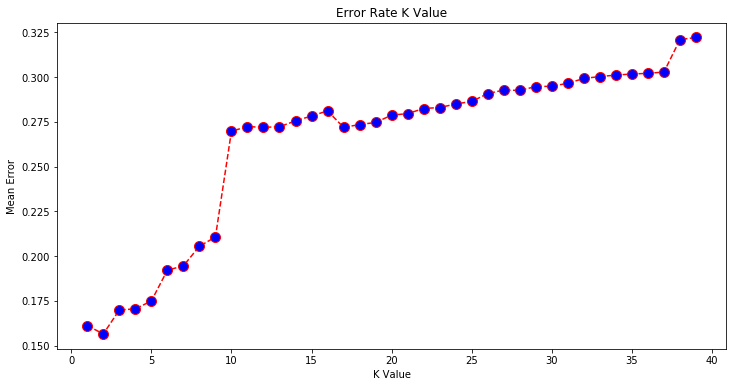

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [75]:
########################### 6 ExtraTreesClassifier ######################################
from sklearn.ensemble import ExtraTreesClassifier
ext = ExtraTreesClassifier()
ext.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [76]:
y_pred = ext.predict(X_test)
print("ACCURACY OF THE EXT TREE MODEL: ", accuracy_score(y_test, y_pred))

ACCURACY OF THE EXT TREE MODEL:  0.9345538259153694


In [77]:
print("CR RF MODEL: ", classification_report(y_test, y_pred, digits=4))

CR RF MODEL:                precision    recall  f1-score   support

        Fake     0.9881    0.9073    0.9460      5761
        Real     0.8606    0.9813    0.9170      3361

    accuracy                         0.9346      9122
   macro avg     0.9244    0.9443    0.9315      9122
weighted avg     0.9411    0.9346    0.9353      9122



In [78]:
########################### 7 GradientBoostingClassifier ######################################
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [79]:
y_pred = gbc.predict(X_test)
print("ACCURACY OF THE GBC MODEL: ", accuracy_score(y_test, y_pred))

ACCURACY OF THE GBC MODEL:  0.931374698531024


In [80]:
print("CR RF MODEL: ", classification_report(y_test, y_pred, digits=4))

CR RF MODEL:                precision    recall  f1-score   support

        Fake     0.9910    0.8995    0.9430      5761
        Real     0.8513    0.9860    0.9137      3361

    accuracy                         0.9314      9122
   macro avg     0.9211    0.9428    0.9284      9122
weighted avg     0.9395    0.9314    0.9322      9122



In [93]:
######################################## Dumping BEst ############
import pickle
filename = 'VGG19+TSBTC+SVM.pkl'
pickle.dump(svm, open(filename, 'wb'))

In [94]:
loaded_model = pickle.load(open(filename, 'rb'))